<a href="https://colab.research.google.com/github/trinay-A/Temp/blob/main/GRU%2BBiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [16]:
tf.random.set_seed(1234)

In [21]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/DataBTC2017.csv')
df.index = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
del df['DATE']
df.rename(
    columns={"DATE": "Time", "CBBTCUSD": "Price"},
    inplace=True,
)
print(df)

               Price
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


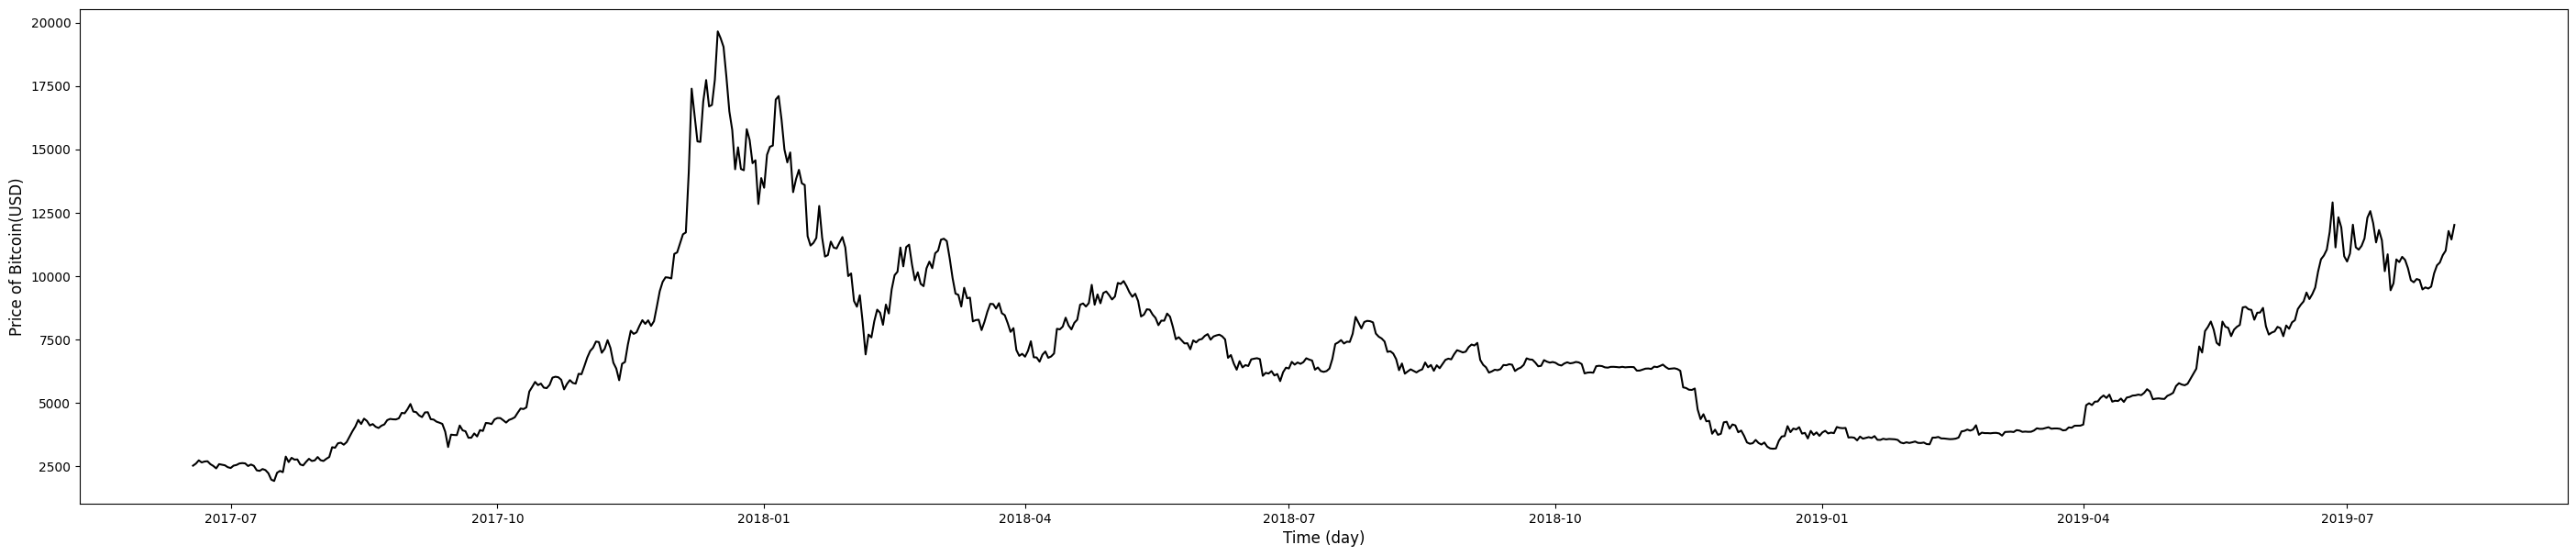

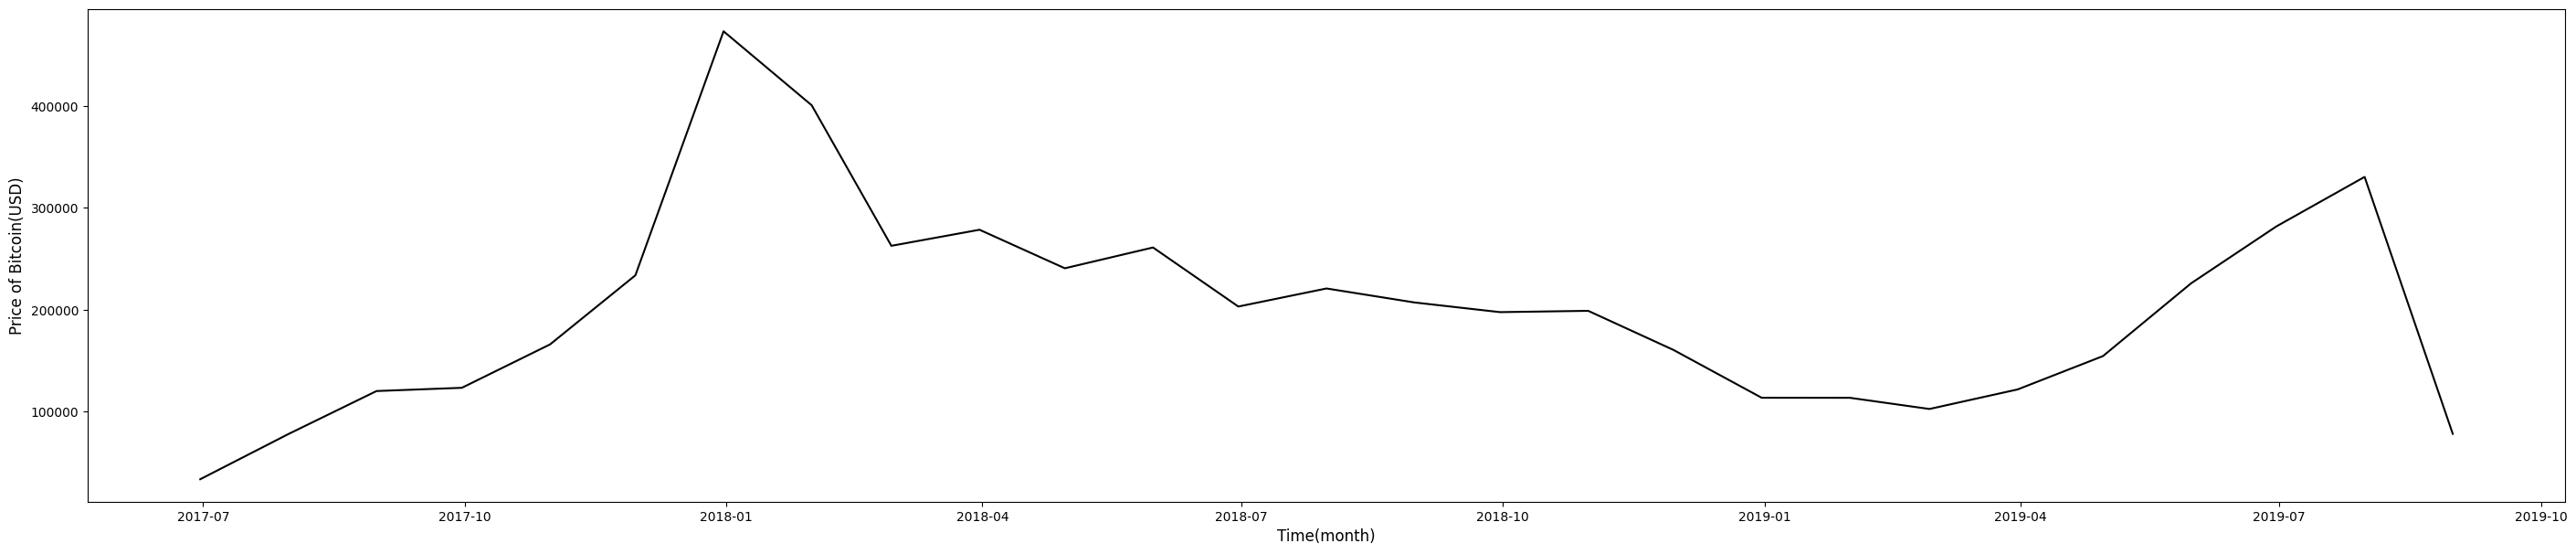

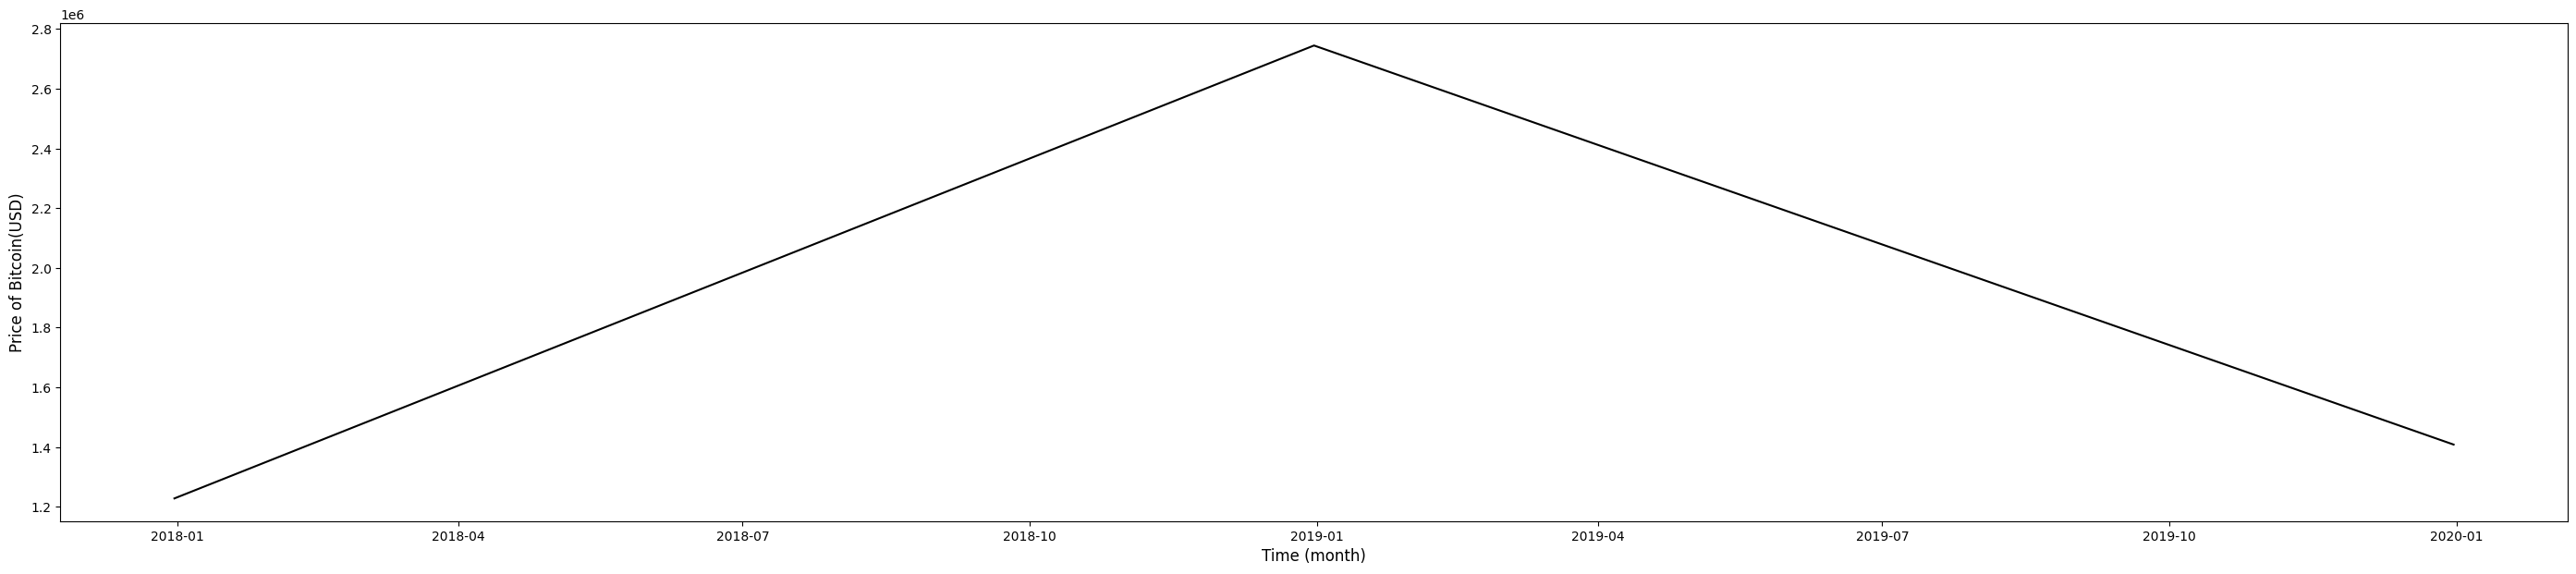

In [22]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (35, 7))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Price of Bitcoin(USD)', 
                                  {'fontsize': 12})
dataset = df.copy()
timeseries(df.index, dataset['Price'], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['Price'], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['Price'], 
           'Time (month)')

In [23]:
# Split train data and test data
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
print(train_data)
print(train_data.shape)

              Price
DATE               
2017-06-18  2515.25
2017-06-19  2596.98
2017-06-20  2725.08
2017-06-21  2643.35
2017-06-22  2679.99
...             ...
2019-02-27  3799.91
2019-02-28  3792.14
2019-03-01  3806.17
2019-03-02  3809.70
2019-03-03  3786.93

[624 rows x 1 columns]
(624, 1)


In [24]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [25]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (594, 30, 1)
y_train.shape:  (594, 1)
X_test.shape:  (127, 30, 1)
y_test.shape:  (127, 1)


In [26]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [27]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
30/30 [==============================] - 8s 67ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 2/100
30/30 [==============================] - 1s 36ms/step - loss: 0.0232 - val_loss: 4.7407e-04
Epoch 3/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0171 - val_loss: 6.3867e-04
Epoch 4/100
30/30 [==============================] - 1s 38ms/step - loss: 0.0109 - val_loss: 2.4139e-04
Epoch 5/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 2.2788e-04
Epoch 6/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0028 - val_loss: 1.5218e-04
Epoch 7/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0028 - val_loss: 1.4711e-04
Epoch 8/100
30/30 [==============================] - 2s 57ms/step - loss: 0.0024 - val_loss: 3.0492e-04
Epoch 9/100
30/30 [==============================] - 2s 66ms/step - loss: 0.0029 - val_loss: 1.4293e-04
Epoch 10/100
30/30 [==============================] - 2s 53ms/step -

In [28]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

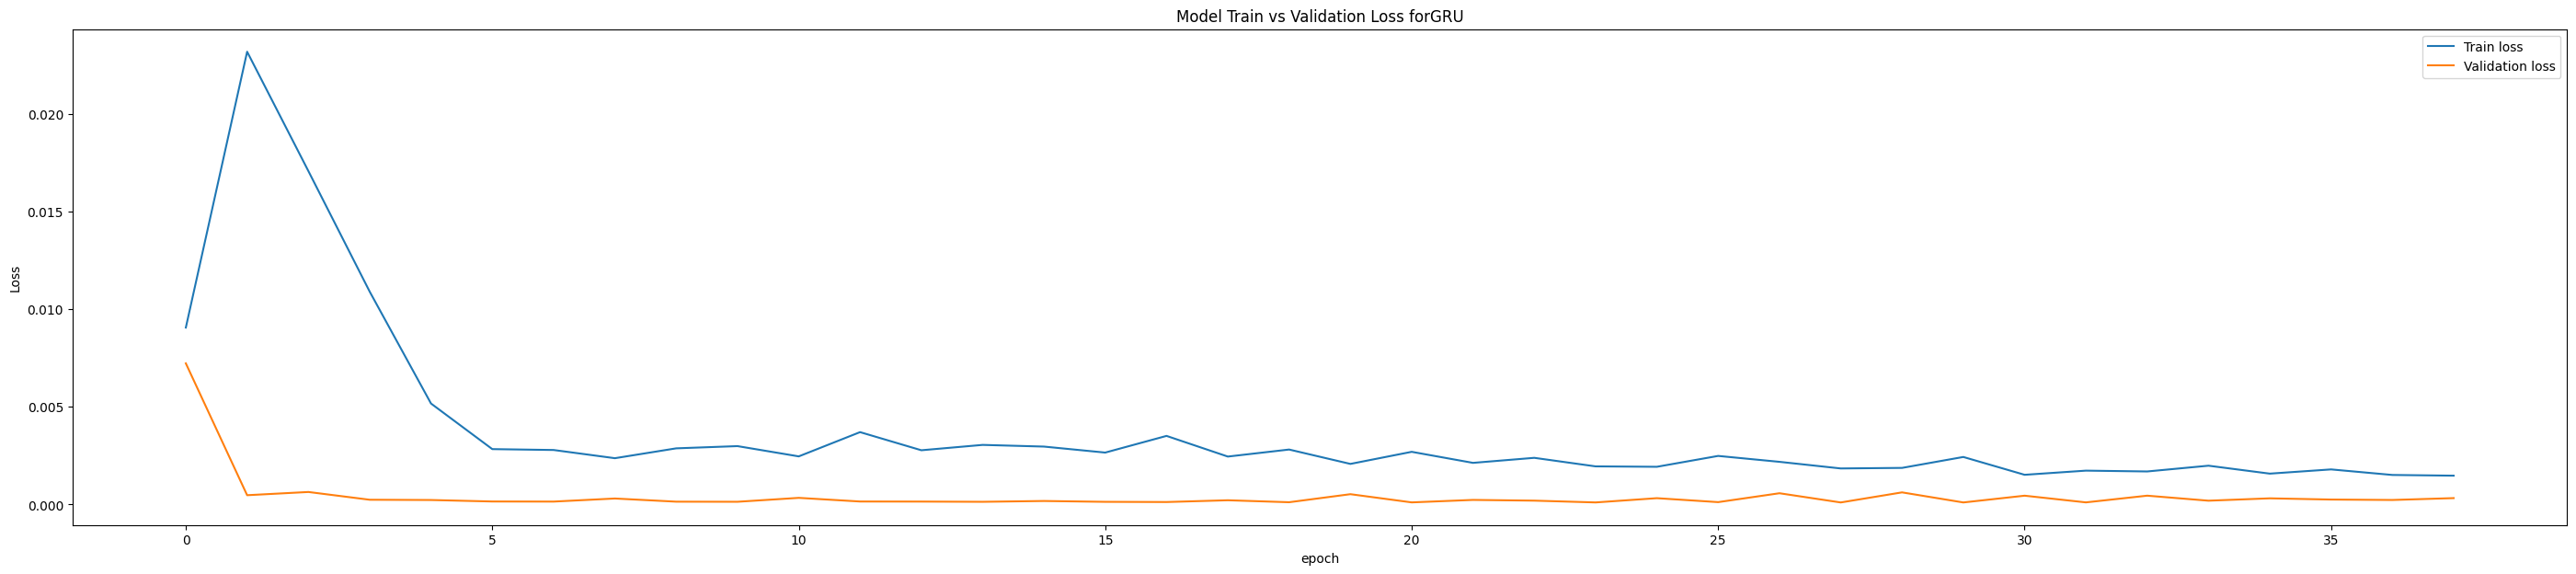

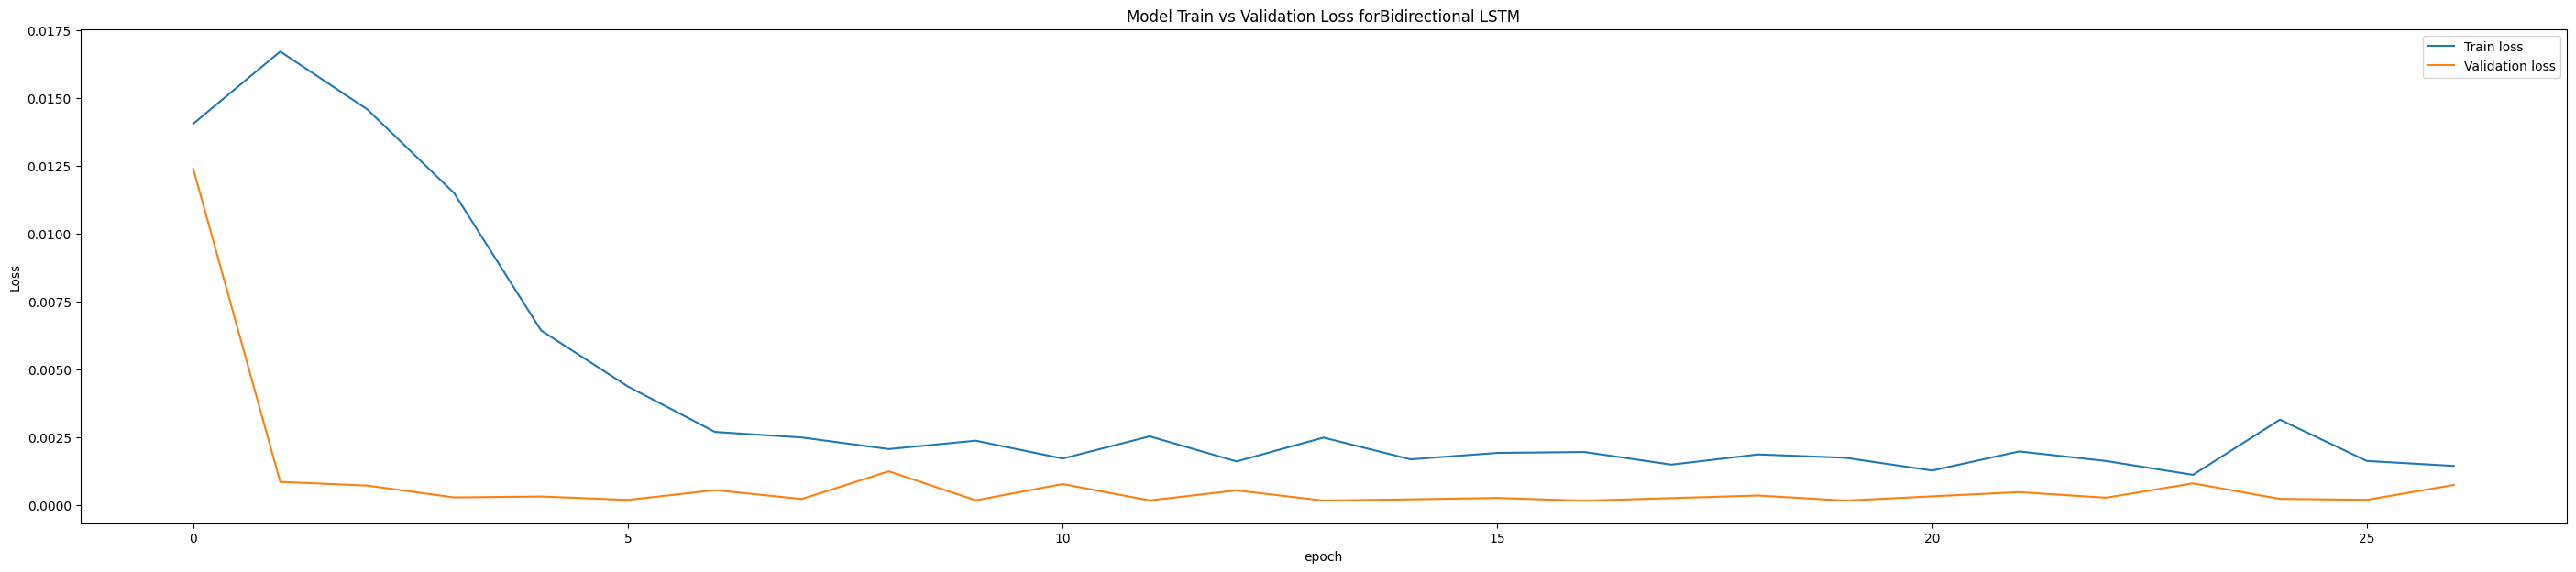

In [29]:
def plot_loss (history, model_name):
    plt.figure(figsize = (35, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for'  + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

4/4 [==============================] - 3s 35ms/step


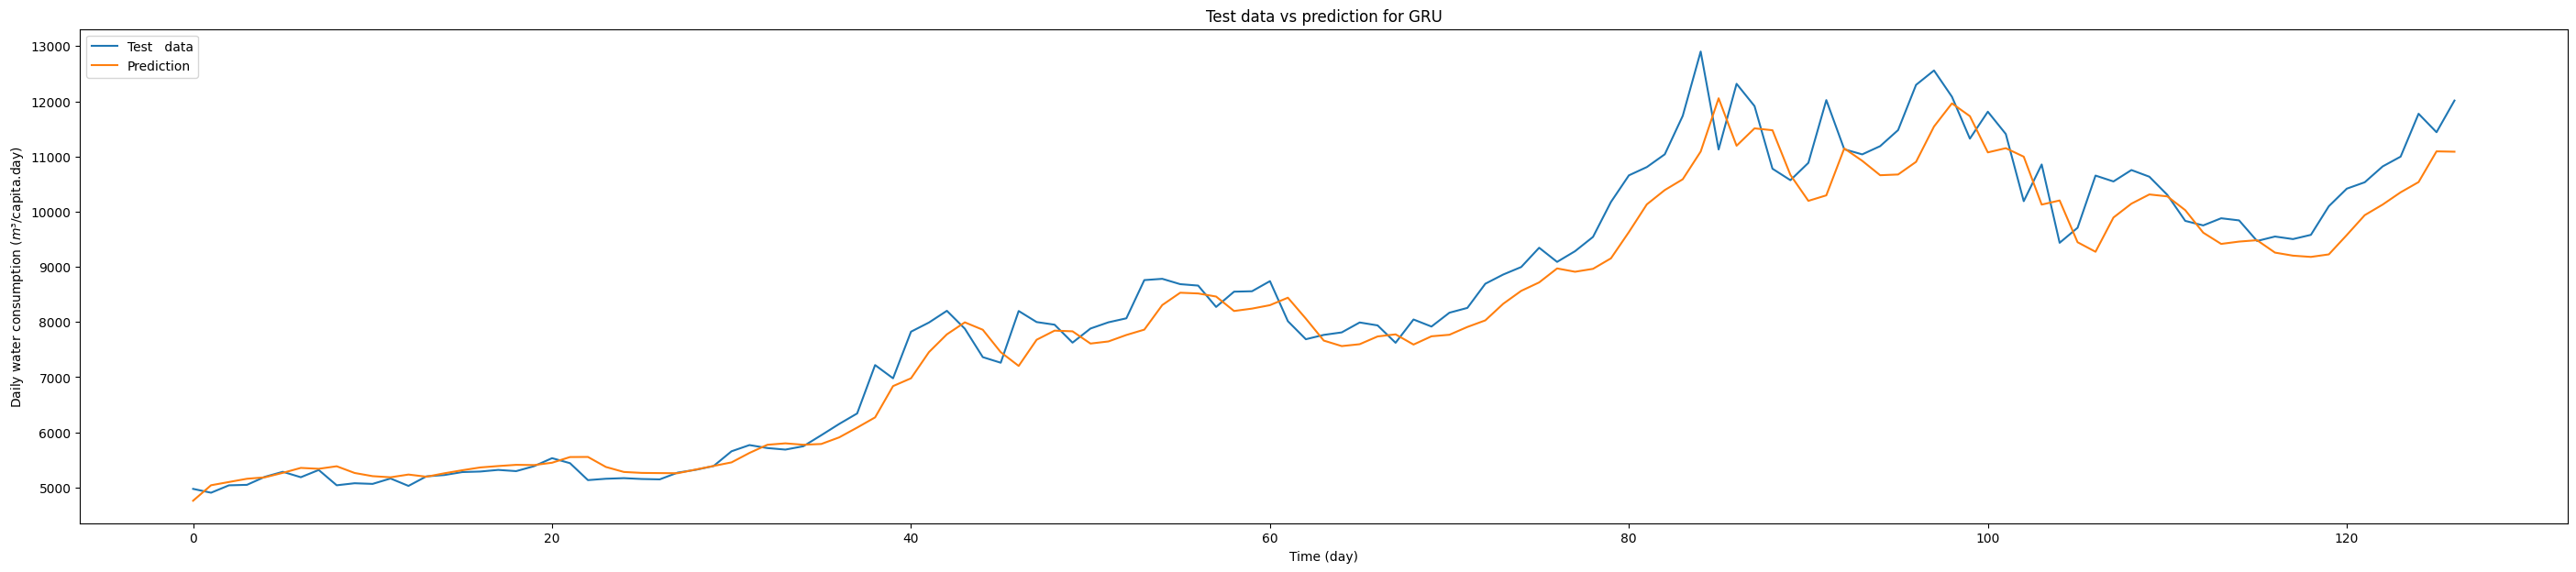

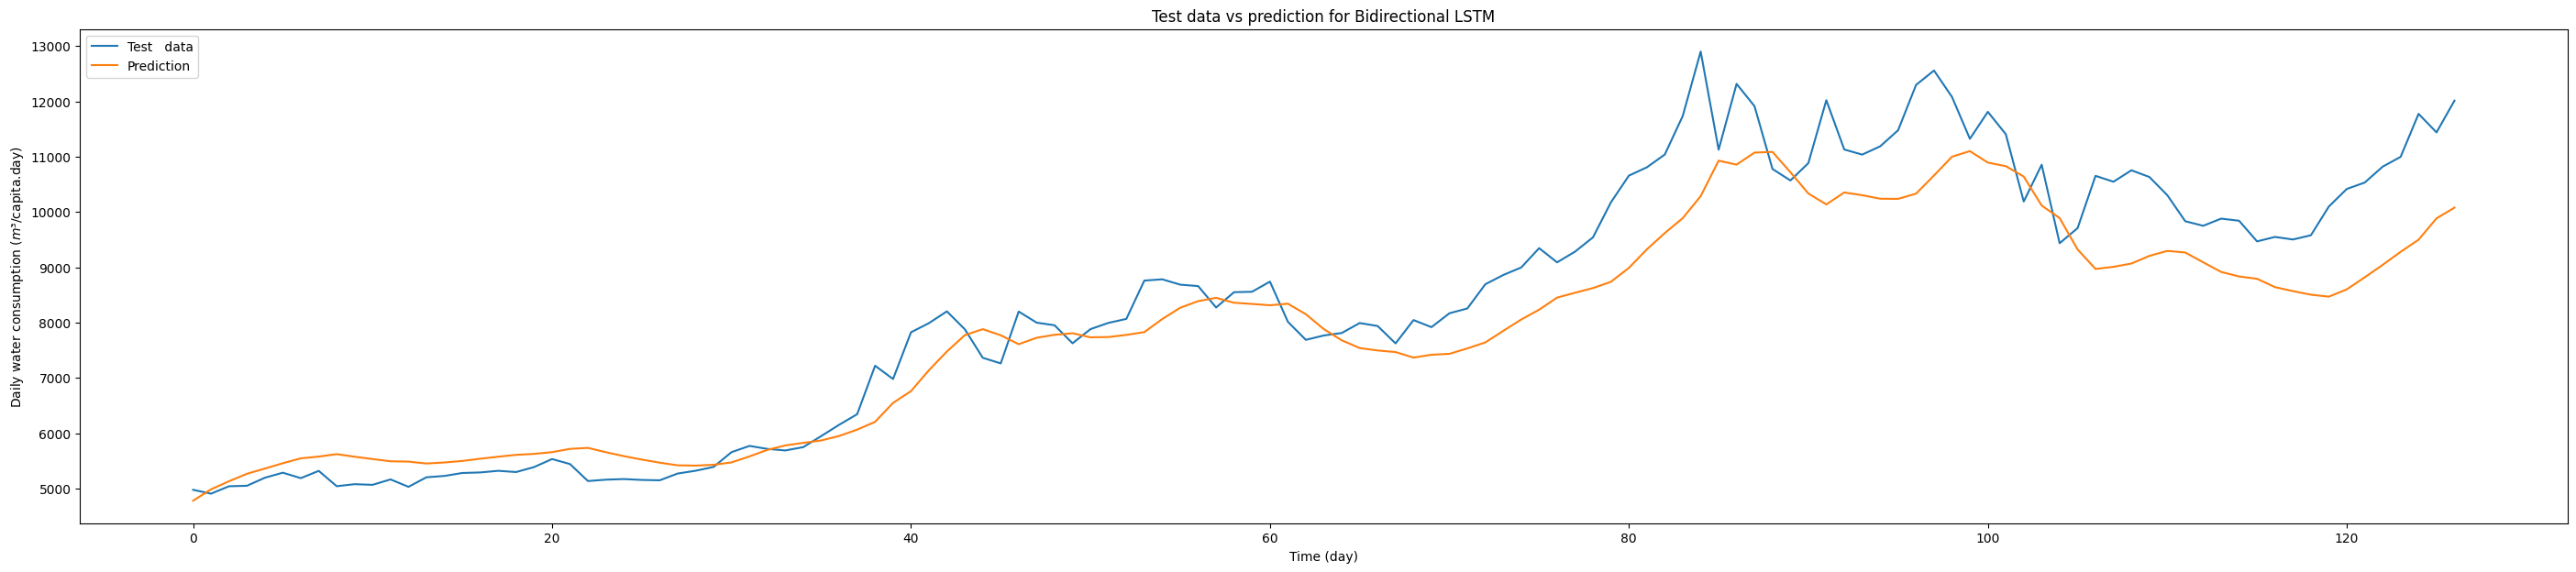

In [30]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(35, 7))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m³$/capita.day)')
 
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [31]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')

GRU:
Mean Absolute Error: 405.2869
Root Mean Square Error: 549.1359

Bidirectional LSTM:
Mean Absolute Error: 693.3568
Root Mean Square Error: 899.5192



In [14]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1, prediction2):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
    plt.plot(range_future, np.array(prediction2),
             label='Forecasted for BiLSTM')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Water demand (lit/day)')
        
plot_multi_step(new_data, prediction_gru, prediction_bilstm)

NameError: ignored